In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import pandas as pd
from torch.utils.data import Dataset, DataLoader, TensorDataset

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
palDf = pd.read_csv('./resource/PalData.csv')
palDf

,1,Name,CodeName,Unnamed: 3,OverrideNameTextID,NamePrefixID,OverridePartnerSkillTextID,IsPal,Tribe,BPClass,...,WorkSuitability_Transport,WorkSuitability_MonsterFarm,PassiveSkill1,PassiveSkill2,PassiveSkill3,PassiveSkill4,IndexOrder,UniqueOnly,Image,ZukanIndexSuffix
0,2,Anubis,Anubis,NaN,NaN,NaN,NaN,True,EPalTribeID::Anubis,Anubis,...,2,0,ElementBoost_Earth_2_PAL,NaN,NaN,NaN,1,False,https://lh7-us.googleusercontent.com/sheets/AM...,NaN
1,3,Incineram,Baphomet,NaN,NaN,NaN,NaN,True,EPalTribeID::Baphomet,Baphomet,...,2,0,NaN,NaN,NaN,NaN,2,False,https://lh7-us.googleusercontent.com/sheets/AM...,NaN
2,4,Incineram Noct,Baphomet_Dark,NaN,NaN,NaN,NaN,True,EPalTribeID::Baphomet_Dark,Baphomet_Dark,...,2,0,NaN,NaN,NaN,NaN,3,True,https://lh7-us.googleusercontent.com/sheets/AM...,B
3,5,Mau,Bastet,NaN,NaN,NaN,NaN,True,EPalTribeID::Bastet,Bastet,...,0,1,NaN,NaN,NaN,NaN,4,False,https://lh7-us.googleusercontent.com/sheets/AM...,NaN
4,6,Mau Cryst,Bastet_Ice,NaN,NaN,NaN,NaN,True,EPalTribeID::Bastet_Ice,Bastet_Ice,...,0,1,NaN,NaN,NaN,NaN,5,True,https://lh7-us.googleusercontent.com/sheets/AM...,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,135,Orserk,ThunderDragonMan,NaN,NaN,NaN,NaN,True,EPalTribeID::ThunderDragonMan,ThunderDragonMan,...,3,0,ElementBoost_Thunder_2_PAL,NaN,NaN,NaN,134,True,https://lh7-us.googleusercontent.com/sheets/AM...,NaN
134,136,Cremis,WoolFox,NaN,NaN,NaN,NaN,True,EPalTribeID::WoolFox,WoolFox,...,0,1,NaN,NaN,NaN,NaN,135,False,https://lh7-us.googleusercontent.com/sheets/AM...,NaN
135,137,Dumud,LazyCatfish,NaN,NaN,NaN,NaN,True,EPalTribeID::LazyCatfish,LazyCatfish,...,1,0,NaN,NaN,NaN,NaN,136,False,https://lh7-us.googleusercontent.com/sheets/AM...,NaN
136,138,Flambelle,LavaGirl,NaN,NaN,NaN,NaN,True,EPalTribeID::LavaGirl,LavaGirl,...,1,1,NaN,NaN,NaN,NaN,137,False,https://lh7-us.googleusercontent.com/sheets/AM...,NaN


# Join elements + hot encoded

In [3]:
palDf["ElementTypes"] = palDf["ElementType1"] + "," + palDf["ElementType2"]
palDf["ElementTypes"] = palDf["ElementTypes"].apply(lambda x: list( filter(lambda y:y != "None",  x.replace("EPalElementType::","").split(",") ) )) 
palDf["Attack"] = ( palDf["MeleeAttack"] + palDf["ShotAttack"] ) /2
interestedStats = ["Name", "Attack", "HP","ElementTypes"]
palDf = palDf[interestedStats]

In [4]:
palDf = palDf.explode('ElementTypes')
df_dummies = pd.get_dummies(palDf, columns=['ElementTypes'])
palDf = df_dummies.groupby('Name', as_index=False).sum()
palDf

,Name,Attack,HP,ElementTypes_Dark,ElementTypes_Dragon,ElementTypes_Earth,ElementTypes_Electricity,ElementTypes_Fire,ElementTypes_Ice,ElementTypes_Leaf,ElementTypes_Normal,ElementTypes_Water
0,Anubis,130.0,120,0,0,1,0,0,0,0,0,0
1,Arsox,97.5,85,0,0,0,0,1,0,0,0,0
2,Astegon,225.0,200,1,1,0,0,0,0,0,0,0
3,Azurobe,170.0,220,0,1,0,0,0,0,0,0,1
4,Beakon,107.5,105,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
133,Warsect,200.0,240,0,0,1,0,0,0,1,0,0
134,Wixen,80.0,90,0,0,0,0,1,0,0,0,0
135,Woolipop,70.0,70,0,0,0,0,0,0,0,1,0
136,Wumpo,90.0,140,0,0,0,0,0,1,0,0,0


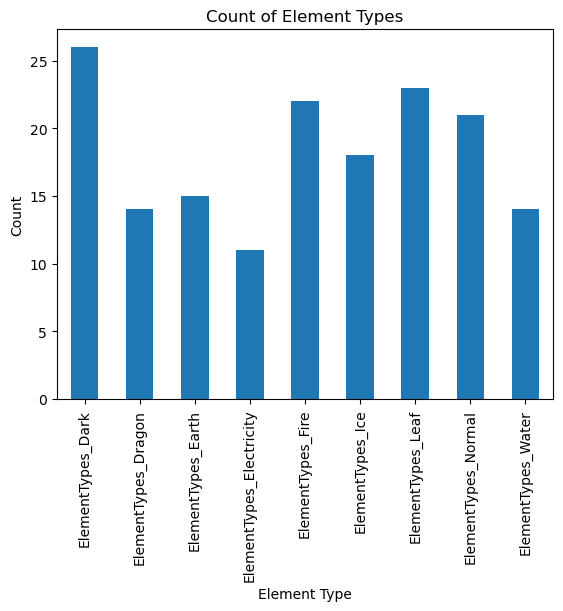

In [5]:
import matplotlib.pyplot as plt
elements = [ "ElementTypes_Dark","ElementTypes_Dragon","ElementTypes_Earth","ElementTypes_Electricity","ElementTypes_Fire","ElementTypes_Ice","ElementTypes_Leaf","ElementTypes_Normal","ElementTypes_Water" ]
element_counts = palDf[elements].sum()
element_counts.plot(kind='bar')
plt.xlabel('Element Type')
plt.ylabel('Count')
plt.title('Count of Element Types')
plt.show()


# Attack and HP distributions

<Axes: ylabel='Frequency'>

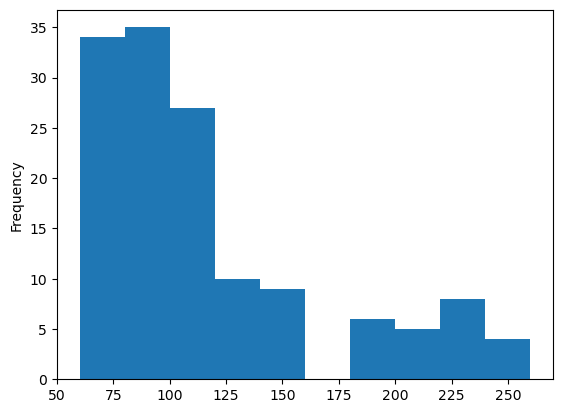

In [6]:
palDf["HP"].plot(kind='hist')

<Axes: ylabel='Frequency'>

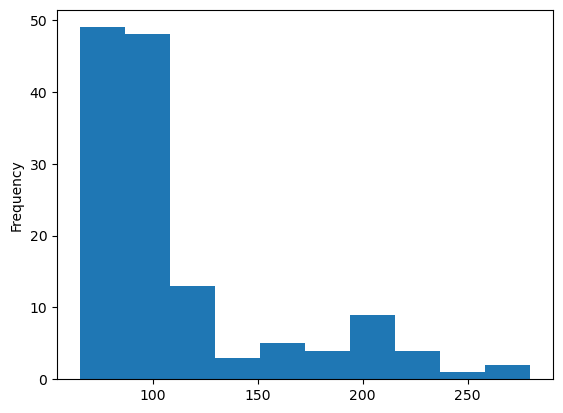

In [7]:
palDf["Attack"].plot(kind='hist')

# Defining parameter grids

In [8]:
import numpy as np
from sklearn.model_selection import ParameterSampler,ParameterGrid
winrateSampleSize = 10
palGrid = ParameterGrid( {
    "HP":np.linspace(palDf["HP"].min(),palDf["HP"].max(), 7 ),
    "Attack":np.linspace(palDf["Attack"].min(),palDf["Attack"].max(), 7 ),
    "AGI":np.linspace( 0.1,0.7,7),
    "CRT":np.linspace( 0.05,0.7,7)
} )

In [9]:
print( len( list(palGrid) ) )

2401


In [10]:
from PalModule import Pal
from Battle import Composer
from Status import  IPalStatus,PalStatusType
from DeriveStatus import AgilityStatus,CriticalStatus

# def createPal(stat,element):
#     pal = Pal(name="dummy1",elements=[element],attack=combi[0]["Attack"],health=combi[0]["HP"],avatar="dummy")
#     pal.defensiveStatus["y"] = AgilityStatus(val=combi[0]["AGI"]*100)
#     pal.offensiveStatus["y"] = CriticalStatus(val=combi[0]["CRT"]*100)

def battle(combi):
    # pal1 = Pal(name="dummy1",elements=["x"],attack=combi[0]["Attack"],health=combi[0]["HP"],avatar="dummy")
    # pal1.defensiveStatus["y"] = AgilityStatus(val=combi[0]["AGI"]*100)
    # pal1.offensiveStatus["y"] = CriticalStatus(val=combi[0]["CRT"]*100)
    # pal2 = Pal(name="dummy2",elements=["y"],attack=combi[1]["Attack"],health=combi[1]["HP"],avatar="dummy")
    # pal1.defensiveStatus["x"] = AgilityStatus(val=combi[1]["AGI"]*100)
    # pal1.offensiveStatus["x"] = CriticalStatus(val=combi[1]["CRT"]*100)
    # winRate = Composer.battle(pal1,pal2,amount=winrateSampleSize)
    return 0.5

# Gen dummy battle data

In [11]:
battleSampler = ParameterSampler({
    "p1":list( palGrid ),
    "p2":list( palGrid )
},n_iter=10000,random_state=42)

In [12]:
import pandas as pd
battles = []
for pair in battleSampler:
    winRate = battle(pair)
    p1 = {key + '1': value for key, value in pair["p1"].items()}
    p2 = {key + '2': value for key, value in pair["p2"].items()}
    battles.append( {**p1, **p2, "winRate":winRate} )
battles = pd.DataFrame(battles)
battles

,AGI1,Attack1,CRT1,HP1,AGI2,Attack2,CRT2,HP2,winRate
0,0.3,65.000000,0.266667,226.666667,0.1,65.000000,0.591667,160.000000,0.5
1,0.6,100.833333,0.483333,60.000000,0.6,244.166667,0.266667,260.000000,0.5
2,0.6,280.000000,0.700000,60.000000,0.6,280.000000,0.375000,160.000000,0.5
3,0.3,208.333333,0.700000,260.000000,0.5,172.500000,0.591667,226.666667,0.5
4,0.2,280.000000,0.266667,126.666667,0.7,100.833333,0.700000,193.333333,0.5
...,...,...,...,...,...,...,...,...,...
9995,0.6,208.333333,0.050000,60.000000,0.3,100.833333,0.483333,226.666667,0.5
9996,0.2,136.666667,0.266667,126.666667,0.7,172.500000,0.158333,60.000000,0.5
9997,0.7,208.333333,0.700000,160.000000,0.1,244.166667,0.700000,226.666667,0.5
9998,0.6,65.000000,0.158333,160.000000,0.7,280.000000,0.483333,260.000000,0.5


In [13]:
from sklearn.model_selection import train_test_split
X = battles.drop(columns=["winRate"])
Y = battles["winRate"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Models Train/test

In [14]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
def evalutate(y_pred):
    print("MSE", mean_squared_error(y_test, y_pred) )
    print("MAE", mean_absolute_error(y_test, y_pred))

## Linear regression

In [15]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(fit_intercept=True)
linear_model.fit(X_train, y_train)
evalutate(linear_model.predict(X_test))

MSE 0.0
MAE 0.0


## Random Forest

In [16]:
from sklearn.ensemble import RandomForestRegressor
forest_model = RandomForestRegressor(n_estimators=100, random_state=0)
forest_model.fit(X_train, y_train)
evalutate(forest_model.predict(X_test))

MSE 0.0
MAE 0.0


## Nueral network

In [17]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()  # To ensure output is between 0 and 1
        )

    def forward(self, x):
        x = self.fc(x)
        return x


# Set the random seed for reproducible results
torch.manual_seed(841)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN().to(device)
print(model)


SimpleNN(
  (fc): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [18]:
# Assuming X and Y are your features and labels
epochs = 1000
lr = 0.001

# Convert features and labels to tensors
X_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32)  # Assuming labels are in [0, 1] range

# Assuming you're using a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create dataset and dataloader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Move model to device
model.to(device)

# Training loop
loss_history = []
for epoch in range(epochs):
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output.squeeze(), y)  # Squeeze the output to match the shape of labels
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())        

    if (epoch+1) % 100 == 0:
        print(f'[Epoch {epoch+1}] Loss: {loss.item()}')

[Epoch 100] Loss: 0.694102942943573
[Epoch 200] Loss: 0.6938039660453796
[Epoch 300] Loss: 0.6936858296394348


[Epoch 400] Loss: 0.6936174631118774
[Epoch 500] Loss: 0.6935709714889526
[Epoch 600] Loss: 0.693536639213562
[Epoch 700] Loss: 0.6935093998908997
[Epoch 800] Loss: 0.6934868693351746
[Epoch 900] Loss: 0.6934677362442017
[Epoch 1000] Loss: 0.6934512257575989
[Epoch 1100] Loss: 0.6934365034103394
[Epoch 1200] Loss: 0.6934234499931335
[Epoch 1300] Loss: 0.693411648273468
[Epoch 1400] Loss: 0.6934008598327637
[Epoch 1500] Loss: 0.693390965461731
[Epoch 1600] Loss: 0.6933819651603699
[Epoch 1700] Loss: 0.693373441696167
[Epoch 1800] Loss: 0.6933654546737671
[Epoch 1900] Loss: 0.6933580040931702
[Epoch 2000] Loss: 0.6933510303497314
[Epoch 2100] Loss: 0.6933443546295166
[Epoch 2200] Loss: 0.69333815574646
[Epoch 2300] Loss: 0.6933321952819824
[Epoch 2400] Loss: 0.6933265328407288
[Epoch 2500] Loss: 0.693321168422699
[Epoch 2600] Loss: 0.6933160424232483
[Epoch 2700] Loss: 0.6933110952377319
[Epoch 2800] Loss: 0.6933063268661499
[Epoch 2900] Loss: 0.6933018565177917
[Epoch 3000] Loss: 0.6932

In [33]:
import numpy as np

# MAybe we can use gradient descent , check out other lab codes
# NO : We do not known the equation of fight because random agi/crit, (maybe possible with using expected value)

def costByMeanWinrate(winrateTable: dict[str, dict[str, float]], accuaryFunction):
    meanWinRates = [(np.mean(list(winrateTable[element].values())))  for element in winrateTable]
    print(meanWinRates,np.full_like(meanWinRates, [0.5]))
    # meanWinRateForall = np.mean(meanWinRates)
    return accuaryFunction(meanWinRates, np.full_like(meanWinRates, [0.5]))


print(costByMeanWinrate({"Hydro": {"Hydro": 0.3, "Pyro": 0.2}, "Pyro": {
      "Hydro": 0.5, "Pyro": 0.5}}, mean_squared_error))


[0.25, 0.5] [0.5 0.5]
0.03125


# Search with rule

In [34]:
ruleDf = pd.read_csv('./resource/PalElementRule.csv')
ruleDf

,index,Normal,Dark,Dragon,Ice,Fire,Water,Electricity,Earth,Leaf
0,Normal,0,-1,0,0,0,0,0,0,0
1,Dark,1,0,-1,0,0,0,0,0,0
2,Dragon,0,1,0,-1,0,0,0,0,0
3,Ice,0,0,1,0,-1,0,0,0,0
4,Fire,0,0,0,0,0,-1,0,0,1
5,Water,0,0,0,0,1,0,-1,0,0
6,Electricity,0,0,0,0,0,1,0,-1,0
7,Earth,0,0,0,0,0,0,1,0,-1
8,Leaf,0,0,0,0,-1,0,0,1,0


In [35]:
# Loading real pals
pals = palTable.apply(lambda row: Pal(row["Name"],
    filter(lambda elem : elem != "None", row[["ElementType1","ElementType2"]].map(lambda x: x.replace("EPalElementType::","")).values) ,
    row[["MeleeAttack","ShotAttack"]].values,
    row["HP"],
    f'./resource/images/{row["Name"]}.png'
), axis=1)

In [ ]:
def palFight(agiTable,crtTable):
    